In [1]:
import mne
#raw = mne.io.read_raw_fif('sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif', preload=True)
#import mne

# Adjust the filename if needed
file_path = '/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif'

epochs = mne.read_epochs(file_path, preload=True)


FileNotFoundError: File does not exist: "c:\Users\audrey-annebeaudry\Downloads\sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif"

In [ ]:
import numpy as np
from mne.time_frequency import tfr_morlet

# Define frequencies of interest (in Hz)
freqs = np.arange(8, 13, 1)   # Alpha: 8–12 Hz
gamma_freqs = np.arange(30, 46, 2)  # Gamma: 30–46 Hz
n_cycles = freqs / 2.0  # More cycles for better freq resolution

# Alpha power
tfr_alpha = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True)
tfr_alpha.plot(picks="eeg", title="Alpha Power (8–12 Hz)")

# Gamma power
tfr_gamma = tfr_morlet(epochs, freqs=gamma_freqs, n_cycles=gamma_freqs / 2.0, return_itc=False, average=True)
tfr_gamma.plot(picks="eeg", title="Gamma Power (30–45 Hz)")


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.8s remaining:    0.0s


No baseline correction applied


[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:  2.6min finished


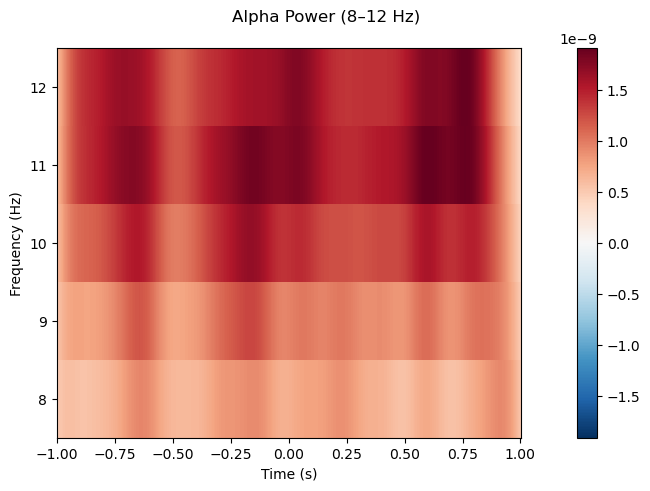

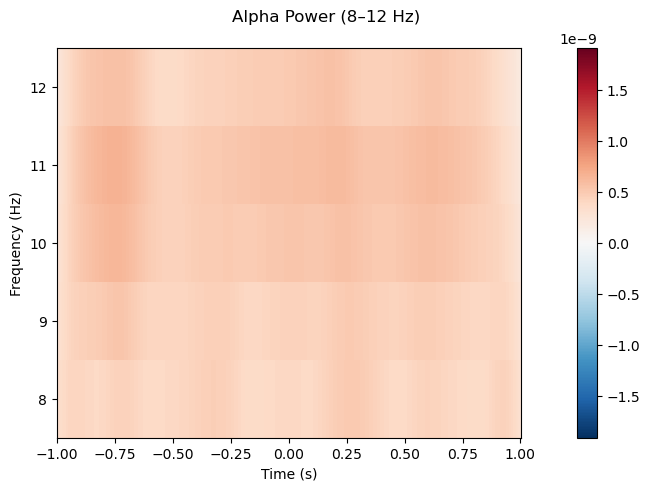

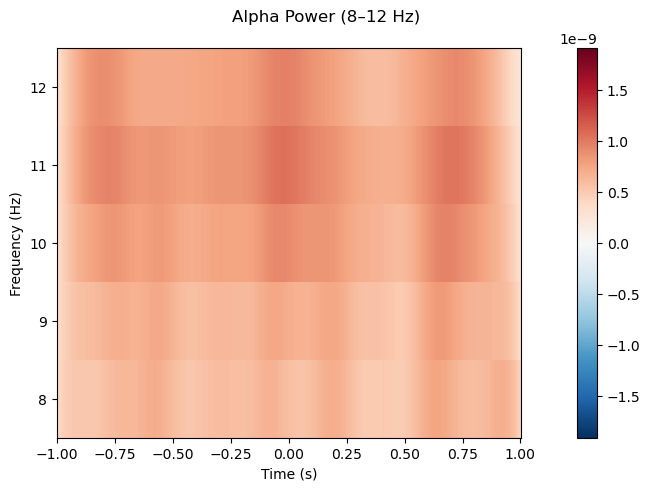

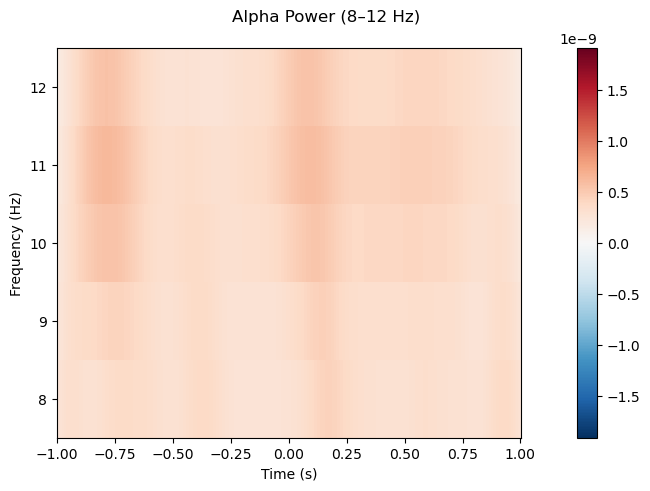

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.0s remaining:    0.0s


KeyboardInterrupt: 

In [12]:
import numpy as np
from mne.time_frequency import tfr_morlet

# Define frequencies of interest (in Hz)
freqs = np.arange(8, 13, 1)   # Alpha: 8–12 Hz
gamma_freqs = np.arange(30, 46, 2)  # Gamma: 30–45 Hz
#n_cycles = freqs / 2.0  # More cycles for better frequency resolution
# Define the electrodes you want to plot
selected_electrodes = ['E59', 'E92', 'E53', 'E87']

# Alpha power
tfr_alpha = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True)
tfr_alpha.plot(picks=selected_electrodes, title="Alpha Power (8–12 Hz)")

# Gamma power
tfr_gamma = tfr_morlet(epochs, freqs=gamma_freqs, n_cycles=gamma_freqs / 2.0, return_itc=False, average=True)
tfr_gamma.plot(picks=selected_electrodes, title="Gamma Power (30–45 Hz)")
#try using multitaper or welch

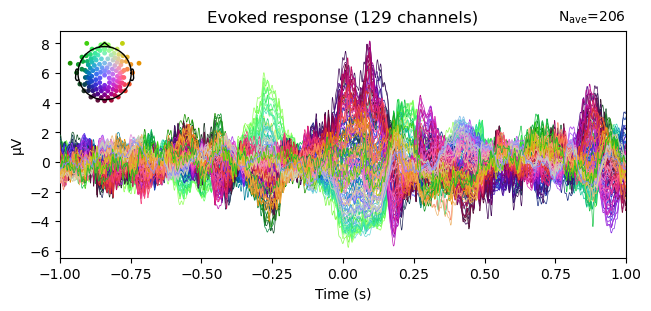

In [17]:
# Compute evoked response
evoked = epochs.average()

# Plot ERP
evoked.plot(picks="eeg", titles="Evoked response")

# Extract peak amplitude and latency for N1 (~100 ms) and P3 (~300 ms)
#n1_latency, n1_amplitude = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)
#p3_latency, p3_amplitude = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)

#print(f"N1 Peak: {n1_amplitude:.2f} µV at {n1_latency*1000:.1f} ms")
#print(f"P3 Peak: {p3_amplitude:.2f} µV at {p3_latency*1000:.1f} ms")


peak_results_n1 = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)
peak_results_p3 = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)

#p3_latency, p3_amplitude = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)

In [20]:
peak_results_n1


('E12', 0.08, -5.0304251107677735e-06)

In [19]:
peak_results_p3

('E77', 0.309, 3.787165931433075e-06)

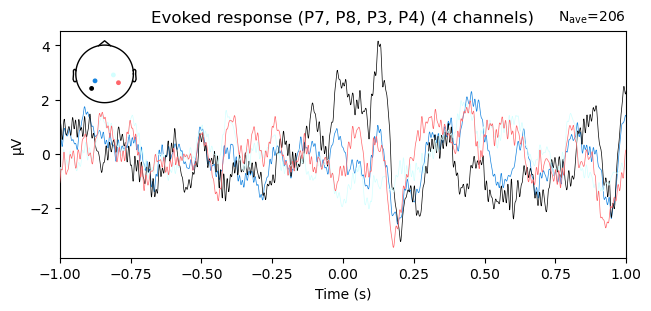

In [26]:
# Pick only electrodes of interest (P7, P8, P3, P4)
selected_electrodes = [59, 92, 53, 87]
picks = ['E53', 'E59', 'E87', 'E92']
# Compute evoked response
evoked = epochs.average(picks=picks)

# Plot ERP for selected channels
evoked.plot(picks=picks, titles="Evoked response (P7, P8, P3, P4)")

# Extract peak amplitude and latency for N1 (~100 ms) and P3 (~300 ms)
peak_results_n1 = evoked.get_peak(tmin=0.08, tmax=0.25, mode='neg', return_amplitude=True)
peak_results_p3 = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)

#print(f"N1 Peak: {n1_amplitude:.2f} µV at {n1_latency*1000:.1f} ms")
#print(f"P3 Peak: {p3_amplitude:.2f} µV at {p3_latency*1000:.1f} ms")


In [27]:
peak_results_p3

('E53', 0.454, 2.2946953252938786e-06)

In [28]:
peak_results_n1

('E92', 0.178, -3.446999213700715e-06)

In [6]:
eeg_channels = [ch for ch in epochs.ch_names if 'EEG' in ch]
print(eeg_channels)
print(epochs.ch_names)

[]
['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E61', 'E62', 'E63', 'E64', 'E65', 'E66', 'E67', 'E68', 'E69', 'E70', 'E71', 'E72', 'E73', 'E74', 'E75', 'E76', 'E77', 'E78', 'E79', 'E80', 'E81', 'E82', 'E83', 'E84', 'E85', 'E86', 'E87', 'E88', 'E89', 'E90', 'E91', 'E92', 'E93', 'E94', 'E95', 'E96', 'E97', 'E98', 'E99', 'E100', 'E101', 'E102', 'E103', 'E104', 'E105', 'E106', 'E107', 'E108', 'E109', 'E110', 'E111', 'E112', 'E113', 'E114', 'E115', 'E116', 'E117', 'E118', 'E119', 'E120', 'E121', 'E122', 'E123', 'E124', 'E125', 'E126', 'E127', 'E128', 'VREF', 'xpos_left', 'ypos_left', 'pupil_left', 'DIN', 'x_head', 'y_head', 'dist

In [7]:
import mne
#raw = mne.io.read_raw_fif('sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif', preload=True)
#import mne
# Adjust the filename if needed
file_path = '/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif'

epochs = mne.read_epochs(file_path, preload=True)


Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
import numpy as np
from mne.time_frequency import tfr_morlet

# Define frequencies of interest (in Hz)
freqs = np.arange(8, 13, 1)   # Alpha: 8–12 Hz
gamma_freqs = np.arange(30, 46, 2)  # Gamma: 30–45 Hz
n_cycles = freqs / 2.0  # More cycles for better freq resolution

# Alpha power
tfr_alpha = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True)
tfr_alpha.plot(picks="eeg", title="Alpha Power (8–12 Hz)")

# Gamma power
tfr_gamma = tfr_morlet(epochs, freqs=gamma_freqs, n_cycles=gamma_freqs / 2.0, return_itc=False, average=True)
tfr_gamma.plot(picks="eeg", title="Gamma Power (30–45 Hz)")

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s


No baseline correction applied


[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:  1.1min finished


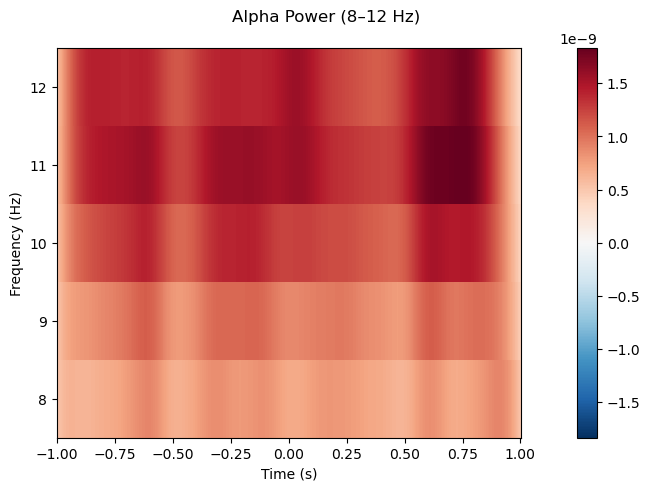

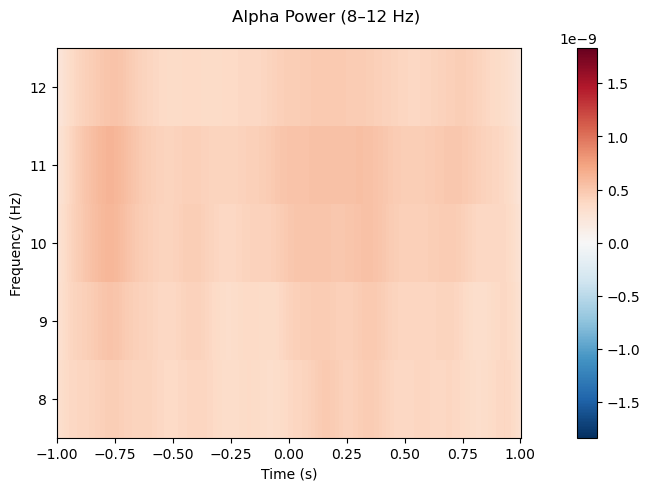

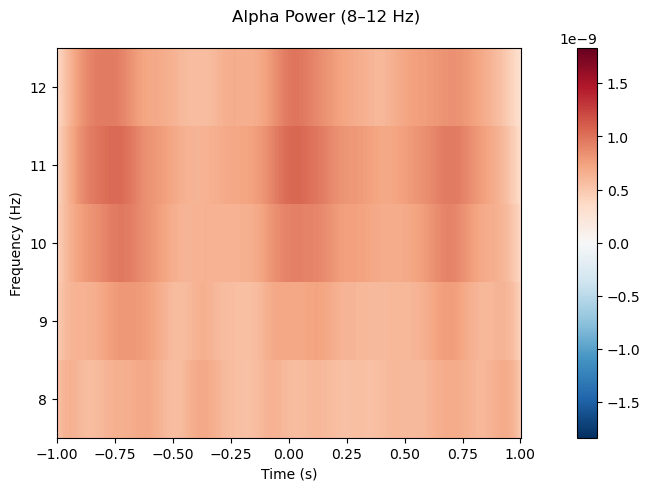

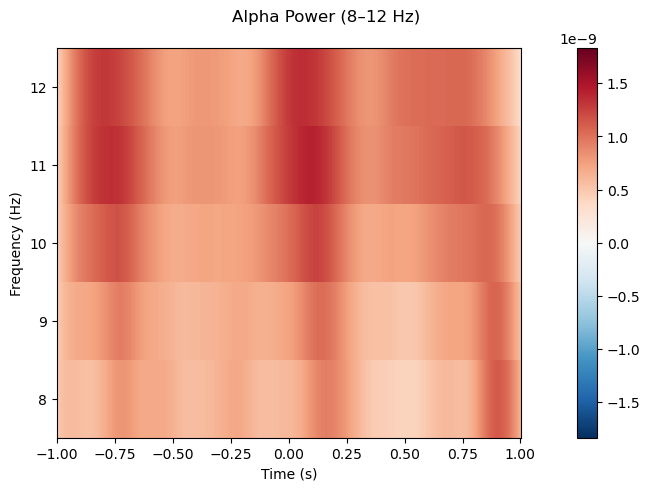

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.4s remaining:    0.0s


No baseline correction applied


[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:  1.8min finished


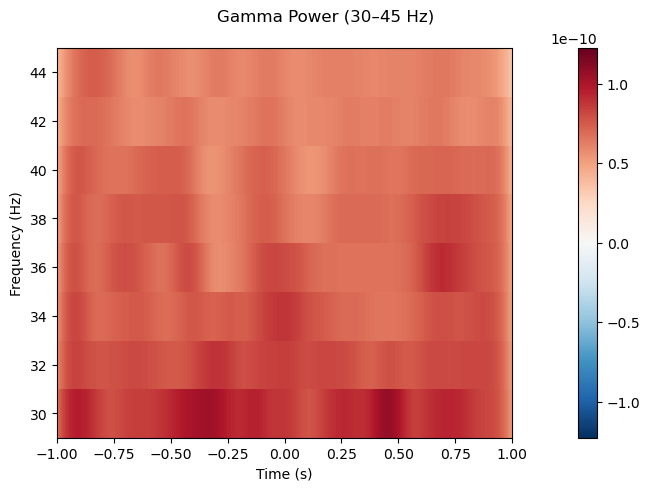

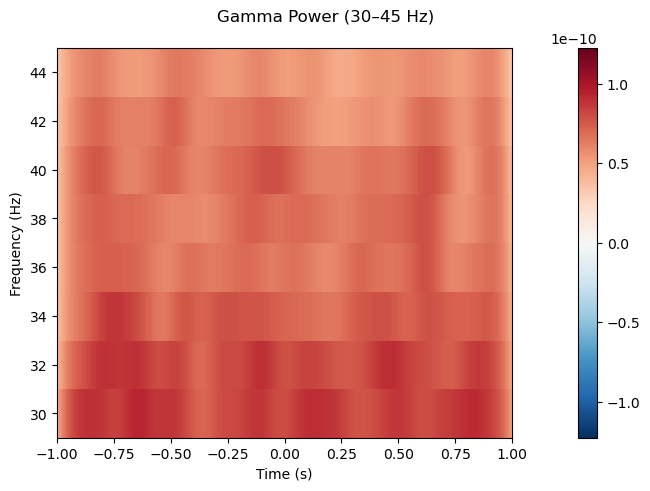

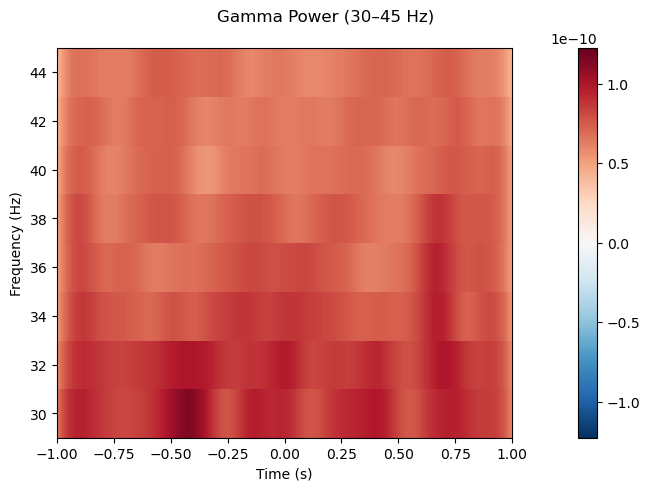

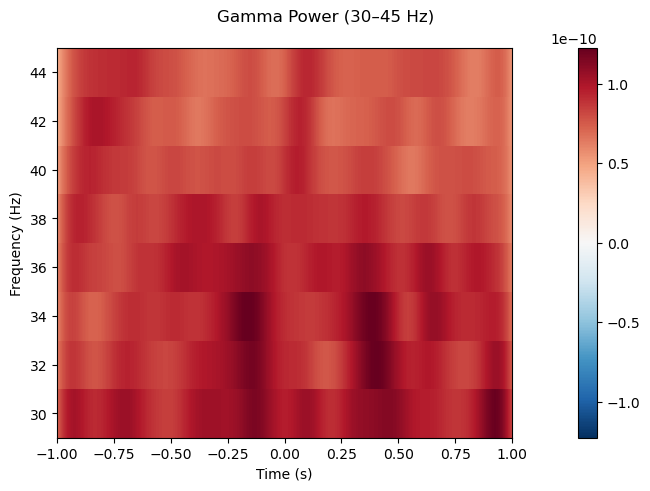

[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>]

In [8]:
import numpy as np
from mne.time_frequency import tfr_morlet

# Define frequencies of interest (in Hz)
freqs = np.arange(8, 13, 1)   # Alpha: 8–12 Hz
gamma_freqs = np.arange(30, 46, 2)  # Gamma: 30–45 Hz
n_cycles = freqs / 2.0  # More cycles for better frequency resolution
# Define the electrodes you want to plot
selected_electrodes = [59, 92, 53, 87]

# Alpha power
tfr_alpha = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True)
tfr_alpha.plot(picks=selected_electrodes, title="Alpha Power (8–12 Hz)")

# Gamma power
tfr_gamma = tfr_morlet(epochs, freqs=gamma_freqs, n_cycles=gamma_freqs / 2.0, return_itc=False, average=True)
tfr_gamma.plot(picks=selected_electrodes, title="Gamma Power (30–45 Hz)")


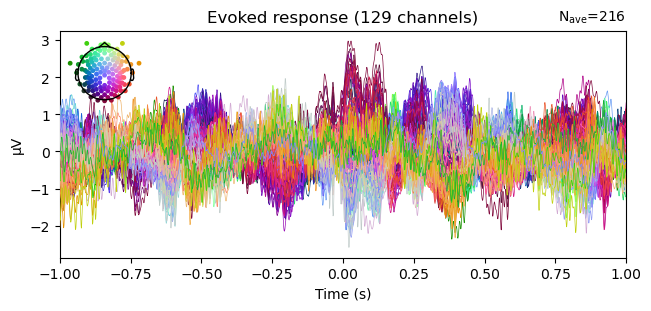

ValueError: too many values to unpack (expected 2)

In [9]:
# Compute evoked response
evoked = epochs.average()

# Plot ERP
evoked.plot(picks="eeg", titles="Evoked response")

# Extract peak amplitude and latency for N1 (~100 ms) and P3 (~300 ms)
n1_latency, n1_amplitude = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)
p3_latency, p3_amplitude = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)

print(f"N1 Peak: {n1_amplitude:.2f} µV at {n1_latency*1000:.1f} ms")
print(f"P3 Peak: {p3_amplitude:.2f} µV at {p3_latency*1000:.1f} ms")


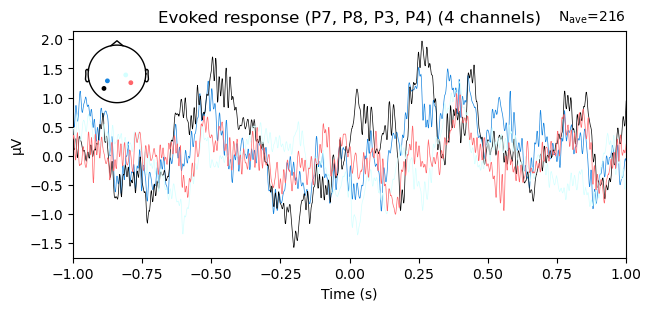

TypeError: Evoked.get_peak() got an unexpected keyword argument 'picks'

In [10]:
# Pick only electrodes of interest (P7, P8, P3, P4)
selected_electrodes = [59, 92, 53, 87]
picks = ['E53', 'E59', 'E87', 'E92']
# Compute evoked response
evoked = epochs.average(picks=picks)

# Plot ERP for selected channels
evoked.plot(picks=picks, titles="Evoked response (P7, P8, P3, P4)")

# Extract peak amplitude and latency for N1 (~100 ms) and P3 (~300 ms)
n1_latency, n1_amplitude = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True, picks=picks)
p3_latency, p3_amplitude = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True, picks=picks)

print(f"N1 Peak: {n1_amplitude:.2f} µV at {n1_latency*1000:.1f} ms")
print(f"P3 Peak: {p3_amplitude:.2f} µV at {p3_latency*1000:.1f} ms")


In [49]:
import mne
import pandas as pd

conj_conditions = [
    'vs/display/search/a5/cc',
    'vs/display/search/a9/cc',
    'vs/display/search/at/cc'
]

# ROIs
roi_channels = ['E59', 'E92', 'E53', 'E87']  # P7, P8, P3, P4
frontal_roi = ['E1', 'E2', 'E3']  # Replace with real frontal channels if needed

# Frequency bands
bands = {'alpha': (8, 13), 'gamma': (30, 45)}

# Final results
all_measures = []

# Epoch files
epoch_files = [
    "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
    "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
]

for filepath in epoch_files:
    print(f"Processing {filepath}")
    ep = mne.read_epochs(filepath, preload=True)

    # Select only conjunction conditions that exist in current file
    existing = [cond for cond in conj_conditions if cond in ep.event_id]
    if not existing:
        print(f"No conjunction conditions found in {filepath}, skipping.")
        continue

    condition_epochs = ep[existing]

    # Average evoked for ROI channels
    evoked = condition_epochs.average(picks=roi_channels)
    # Get N1 (~100ms, negative peak)
    # Get N1 (~100ms, negative peak)
    n1_lat, n1_chan, n1_amp = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)
    p3_lat, p3_chan, p3_amp = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)
    

    # Compute PSD using multitaper, only EEG channels
    picks = mne.pick_types(condition_epochs.info, eeg=True)
    psd = condition_epochs.compute_psd(method='multitaper', fmin=1, fmax=40, picks=picks)
    psds, freqs = psd.get_data(return_freqs=True)

    # Average across epochs
    avg_psd = psds.mean(axis=0)  # shape: (n_channels, n_freqs)

    # Get correct channel names for picked channels
    picked_ch_names = [condition_epochs.ch_names[i] for i in picks]

    # Create PSD DataFrame
    psd_df = pd.DataFrame(avg_psd, index=picked_ch_names, columns=freqs)

    # Band power calculation (on frontal ROI)
    band_powers = {}
    for band_name, (fmin, fmax) in bands.items():
        try:
            band_power = psd_df.loc[frontal_roi, (psd_df.columns > fmin) & (psd_df.columns < fmax)].mean().mean()
        except KeyError:
            band_power = None  # If some frontal channels are missing
        band_powers[band_name] = band_power

    # Get subject and diagnosis
    subject_id = filepath.split('/')[-1].split('-')[1].split('_')[0]
    diagnosis = 'asd' if 'P' in subject_id else 'control'

    # Append all measures to list
    all_measures.append({
        'subject': subject_id,
        'diagnosis': diagnosis,
        'N1_amp': n1_amp,
        'N1_lat': n1_chan,
        'N1_chan': n1_lat,
        'P3b_amp': p3_amp,
        'P3b_lat': p3_chan,
        'P3b_chan': p3_lat,
        'alpha_power': band_powers.get('alpha'),
        'gamma_power': band_powers.get('gamma')
    })

# Final DataFrame
results_df = pd.DataFrame(all_measures)
print(results_df)
results_df

Processing /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Processing /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
  subject diagnosis    N1_amp  N1_lat N1_chan   P3b_amp  P3b_l

,subject,diagnosis,N1_amp,N1_lat,N1_chan,P3b_amp,P3b_lat,P3b_chan,alpha_power,gamma_power
0,1109P,asd,-0.000006,0.129,E87,0.000011,0.381,E59,1.776430e-09,1.631093e-10
1,1109M1,control,-0.000004,0.098,E87,0.000003,0.428,E59,7.027686e-10,1.390972e-10


In [53]:
import numpy as np

# Assuming you already have:
# - psds: shape (n_epochs, n_channels, n_freqs)
# - freqs: array of frequency bins
# - condition_epochs: your Epochs object

# Define frequency bands
bands = {
    'alpha': (8, 13),
    'gamma': (30, 40)
}

# Average over epochs to get (n_channels, n_freqs)
mean_psd = psds.mean(axis=0)

# Get EEG channel names
picks = mne.pick_types(condition_epochs.info, eeg=True)
chan_names = [condition_epochs.ch_names[i] for i in picks]

# Compute power per channel and find peak channel per band
band_power_results = {}

for band_name, (fmin, fmax) in bands.items():
    freq_inds = np.where((freqs >= fmin) & (freqs <= fmax))[0]
    
    # Integrate power over the frequency band for each channel
    band_power = np.trapz(mean_psd[:, freq_inds], freqs[freq_inds], axis=1)  # shape: (n_channels,)
    
    # Get channel with max power
    max_idx = np.argmax(band_power)
    max_power = band_power[max_idx]
    max_channel = chan_names[max_idx]
    
    # Store results
    band_power_results[f'{band_name}_power'] = max_power
    band_power_results[f'{band_name}_chan'] = max_channel

# Display results
for key, value in band_power_results.items():
    print(f"{key}: {value}")

alpha_power: 9.550206995286632e-09
alpha_chan: E76
gamma_power: 4.407287483398404e-09
gamma_chan: E126


In [32]:
new_epoch = mne.read_epochs(filepath, preload=True)
print(new_epoch.event_id)


Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
{'da5a': 13, 'da5c': 14, 'da5s': 15, 'da9a': 16, 'da9c': 17, 'da9s': 18, 'da_d': 19, 'datc': 20, 'db5a': 21, 'db5c': 22, 'db9a': 23, 'db9c': 24, 'db9s': 25, 'dbtc': 26, 'df5a': 27, 'df5c': 28, 'df5s': 29, 'df9a': 30, 'df9c': 31, 'df9s': 32, 'dftc': 33, 'dr5a': 34, 'dr5c': 35, 'dr5s': 36, 'dr9a': 37, 'dr9c': 38, 'dr9s': 39, 'drtc': 40, 'ga5a': 55, 'ga5c': 56, 'ga5s': 57, 'ga9c': 58, 'ga9s': 59, 'gatc': 60, 'gt5a': 61, 'gt5c': 62, 'gt5s': 63, 'gt9a': 64, 'gt9c': 65, 'gt9s': 66, 'gttc': 67, 'vs/display/search/a5/ca': 41, 'vs/display/search/a5/cc': 42, 'vs/display/search/a5/cs': 43, 'vs/display/search/a9/ca': 44, 'vs/display/search/a9/cc': 45, 'vs/display/search/a9/cs': 46, 'vs